<a href="https://colab.research.google.com/github/cstepgit/Multi-class-classification-/blob/main/Multi_Class_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.5 MB/s eta 0:00:00


In [ ]:
pip install optuna-integration[pytorch_lightning]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
pip install torchvision

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import optuna
from optuna.integration import PyTorchLightningPruningCallback

In [ ]:
# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the MNIST dataset
full_train_dataset = datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# Split the dataset
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size])

# Set device
SEED = 13
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 487kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.43MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Using device: cuda


In [ ]:
class CNNNet(nn.Module):
    def __init__(self, hidden1_units, hidden2_units, dropout_rate):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden1_units, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(hidden1_units)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(hidden1_units, hidden2_units, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(hidden2_units)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden2_units * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool(self.relu2(self.bn2(self.conv2(x))))
        x = x.view(-1, self.num_flat_features(x))
        x = self.dropout(self.fc1(x))
        x = self.fc2(x)
        return x

    def num_flat_features(self, x):
        return x.size(1) * x.size(2) * x.size(3)


In [ ]:
def objective(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    hidden1_units = trial.suggest_int('hidden1_units', 32, 128, step=32)
    hidden2_units = trial.suggest_int('hidden2_units', 64, 256, step=64)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    scheduler_step_size = trial.suggest_int('scheduler_step_size', 3, 7)
    scheduler_gamma = trial.suggest_uniform('scheduler_gamma', 0.1, 0.5)

    # Create DataLoaders with the suggested batch size
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True if device.type == 'cuda' else False)
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if device.type == 'cuda' else False)

    # Initialize the model, loss function, optimizer, and scheduler
    model = CNNNet(hidden1_units, hidden2_units, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

    # Use mixed precision training
    scaler = torch.cuda.amp.GradScaler()

    num_epochs = 2
    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_steps = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            total_steps += 1

        scheduler.step()

        # Validation step
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        best_val_accuracy = max(best_val_accuracy, val_accuracy)
        trial.report(val_accuracy, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Accuracy: {val_accuracy:.2f}%')

    return best_val_accuracy


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

# Print the best hyperparameters
print("\nBest hyperparameters:", study.best_params)

# Evaluate on the test set using the best hyperparameters
best_params = study.best_params
batch_size = best_params['batch_size']
hidden1_units = best_params['hidden1_units']
hidden2_units = best_params['hidden2_units']
dropout_rate = best_params['dropout_rate']
learning_rate = best_params['learning_rate']
scheduler_step_size = best_params['scheduler_step_size']
scheduler_gamma = best_params['scheduler_gamma']

# Create DataLoaders with the best batch size
train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True if device.type == 'cuda' else False)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if device.type == 'cuda' else False)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True if device.type == 'cuda' else False)

# Initialize the model, loss function, optimizer, and scheduler
model = CNNNet(hidden1_units, hidden2_units, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma)

# Use mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Retrain with the best hyperparameters
num_epochs_retrain = 2
for epoch in range(num_epochs_retrain):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
    scheduler.step()
    print(f'Retrain Epoch [{epoch+1}/{num_epochs_retrain}], Loss: {running_loss/len(train_loader):.4f}')


# Test the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'\nTest Accuracy with optimized hyperparameters: {test_accuracy:.2f}%')

[I 2024-12-21 03:39:21,144] A new study created in memory with name: no-name-622c13a7-95ef-4769-bc07-e8c43faa85e9
<ipython-input-6-d873faeb421e>:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)
<ipython-input-6-d873faeb421e>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
<ipython-input-6-d873faeb421e>:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  scheduler_gamma = trial.suggest_uniform('scheduler_gamma', 0.1, 0.

Epoch [1/2], Validation Accuracy: 93.46%


[I 2024-12-21 03:40:10,097] Trial 0 finished with value: 93.54166666666667 and parameters: {'learning_rate': 0.0003992477732472715, 'batch_size': 128, 'hidden1_units': 96, 'hidden2_units': 192, 'dropout_rate': 0.39263809532333604, 'scheduler_step_size': 7, 'scheduler_gamma': 0.22627613305573366}. Best is trial 0 with value: 93.54166666666667.


Epoch [2/2], Validation Accuracy: 93.54%
Epoch [1/2], Validation Accuracy: 91.59%


[I 2024-12-21 03:40:59,025] Trial 1 finished with value: 95.11666666666666 and parameters: {'learning_rate': 0.006854619950358967, 'batch_size': 128, 'hidden1_units': 32, 'hidden2_units': 192, 'dropout_rate': 0.3052867974718904, 'scheduler_step_size': 4, 'scheduler_gamma': 0.36255527584562963}. Best is trial 1 with value: 95.11666666666666.


Epoch [2/2], Validation Accuracy: 95.12%
Epoch [1/2], Validation Accuracy: 92.22%


[I 2024-12-21 03:42:01,415] Trial 2 finished with value: 93.38333333333334 and parameters: {'learning_rate': 0.00048589528269583297, 'batch_size': 32, 'hidden1_units': 32, 'hidden2_units': 64, 'dropout_rate': 0.28650505911670443, 'scheduler_step_size': 6, 'scheduler_gamma': 0.292401427010344}. Best is trial 1 with value: 95.11666666666666.


Epoch [2/2], Validation Accuracy: 93.38%
Epoch [1/2], Validation Accuracy: 93.56%


[I 2024-12-21 03:43:06,547] Trial 3 finished with value: 95.79166666666667 and parameters: {'learning_rate': 0.0012880696914507996, 'batch_size': 32, 'hidden1_units': 96, 'hidden2_units': 192, 'dropout_rate': 0.2762118439088504, 'scheduler_step_size': 5, 'scheduler_gamma': 0.32736107763627453}. Best is trial 3 with value: 95.79166666666667.


Epoch [2/2], Validation Accuracy: 95.79%
Epoch [1/2], Validation Accuracy: 92.79%


[I 2024-12-21 03:44:08,443] Trial 4 finished with value: 95.55 and parameters: {'learning_rate': 0.00023810899933615772, 'batch_size': 32, 'hidden1_units': 128, 'hidden2_units': 128, 'dropout_rate': 0.26471698068728505, 'scheduler_step_size': 5, 'scheduler_gamma': 0.3089516920857669}. Best is trial 3 with value: 95.79166666666667.


Epoch [2/2], Validation Accuracy: 95.55%
Epoch [1/2], Validation Accuracy: 92.95%


[I 2024-12-21 03:45:01,867] Trial 5 pruned. 


Epoch [1/2], Validation Accuracy: 94.80%


[I 2024-12-21 03:45:54,617] Trial 6 pruned. 


Epoch [1/2], Validation Accuracy: 93.20%


[I 2024-12-21 03:47:00,955] Trial 7 pruned. 
[I 2024-12-21 03:47:26,125] Trial 8 pruned. 


Epoch [1/2], Validation Accuracy: 93.56%


[I 2024-12-21 03:48:16,694] Trial 9 pruned. 



Best hyperparameters: {'learning_rate': 0.0012880696914507996, 'batch_size': 32, 'hidden1_units': 96, 'hidden2_units': 192, 'dropout_rate': 0.2762118439088504, 'scheduler_step_size': 5, 'scheduler_gamma': 0.32736107763627453}


<ipython-input-7-d503511bd48a>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-7-d503511bd48a>:45: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Retrain Epoch [1/2], Loss: 1.3198
Retrain Epoch [2/2], Loss: 0.2055

Test Accuracy with optimized hyperparameters: 96.26%


In [ ]:
from sklearn.metrics import f1_score
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Test F1 Score with optimized hyperparameters: {f1:.2f}')


Test F1 Score with optimized hyperparameters: 0.96


In [ ]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

In [ ]:
from optuna.visualization import plot_param_importances

plot_param_importances(study)

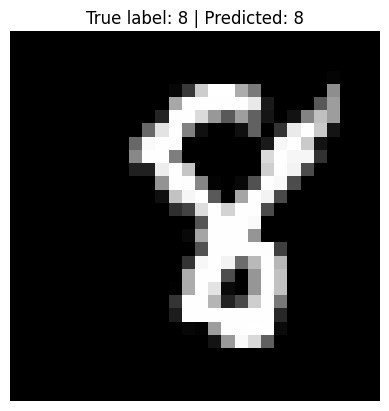

Inference time: 0.001973 seconds


In [ ]:
import matplotlib.pyplot as plt
import random
import time

sample_index = random.randint(0, len(test_dataset) - 1)
sample, label = test_dataset[sample_index]
sample_for_model = sample.unsqueeze(0).to(device)


start_time = time.time()
model = model.to(device)
with torch.no_grad():
    output = model(sample_for_model)
end_time = time.time()
inference_time = end_time - start_time


predicted_class = torch.argmax(output, dim=1).item()
plt.imshow(sample.squeeze(), cmap='gray')
plt.title(f"True label: {label} | Predicted: {predicted_class}")
plt.axis('off')
plt.show()

print(f"Inference time: {inference_time:.6f} seconds")

In [ ]:
print(len(full_train_dataset))

60000
